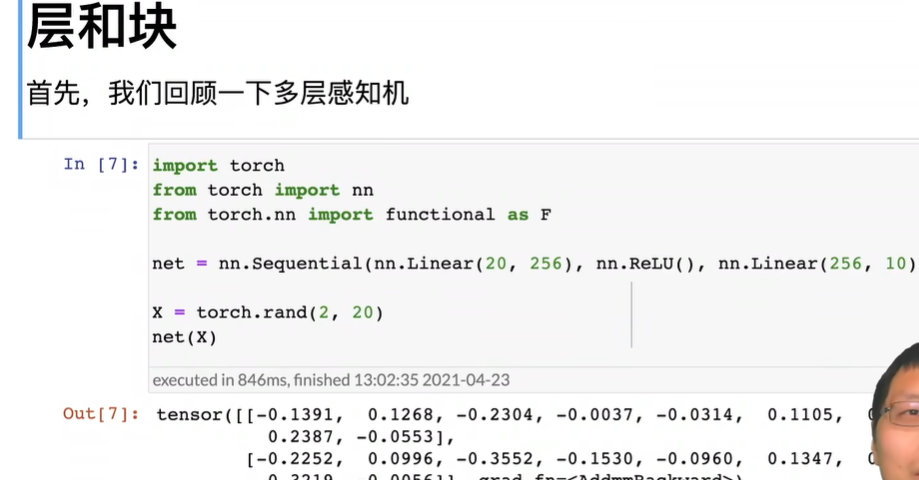

 注意，单个神经网络 （1）接受一些输入； （2）生成相应的标量输出； （3）具有一组相关 参数（parameters），更新这些参数可以优化某目标函数。

In [2]:
#怎么构造层和块 的概念
import torch
from torch import nn
from torch.nn import functional as F



#网络是构造一个线性层+一次ReLU函数+一个线性层
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

#输入维度为20 输出维度为10

# PyTorch 中定义的一个层，用于在神经网络中添加 ReLU（Rectified Linear Unit）激活函数。
# ReLU 是一种常用的非线性激活函数，它将输入中的所有负值变为0，而正值保持不变。

X = torch.rand(2, 20)  #2是批量大小 20是维度
net(X)

tensor([[-0.1119, -0.0640, -0.2774,  0.0521,  0.1609, -0.0071, -0.0106, -0.0674,
         -0.1269, -0.1302],
        [-0.1283,  0.0069, -0.1163,  0.0326,  0.1045, -0.0398,  0.0568, -0.0661,
         -0.0950, -0.0893]], grad_fn=<AddmmBackward0>)

将输入数据作为其前向传播函数的参数。

通过前向传播函数来生成输出。请注意，输出的形状可能与输入的形状不同。例如，我们上面模型中的第一个全连接的层接收一个20维的输入，但是返回一个维度为256的输出。

计算其输出关于输入的梯度，可通过其反向传播函数进行访问。通常这是自动发生的。

存储和访问前向传播计算所需的参数。

根据需要初始化模型参数。

In [3]:
#自定义块 包含一个256个单元的隐藏层 和一个10维的输出层
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X): #输入是x 输出先将x放在隐藏层中在经过relu函数
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))

In [5]:
net = MLP()
X = torch.rand(2, 20)  #2是批量大小 20是维度
net(X)

tensor([[ 0.3964, -0.0591, -0.2030,  0.0219,  0.0399,  0.0575, -0.1233, -0.0732,
          0.1335,  0.1863],
        [ 0.3663, -0.0688, -0.0464, -0.1095, -0.0427,  0.0991, -0.1504, -0.0714,
          0.0480,  0.0457]], grad_fn=<AddmmBackward0>)

5.1.2. 顺序块
现在我们可以更仔细地看看Sequential类是如何工作的， 回想一下Sequential的设计是为了把其他模块串起来。 为了构建我们自己的简化的MySequential， 我们只需要定义两个关键函数：

一种将块逐个追加到列表中的函数；

一种前向传播函数，用于将输入按追加块的顺序传递给块组成的“链条”。

下面的MySequential类提供了与默认Sequential类相同的功能。

In [6]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这里，module是Module子类的一个实例。我们把它保存在'Module'类的成员
            # 变量_modules中。_module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

In [7]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)
#同下

tensor([[ 0.0024, -0.0197,  0.2585,  0.2168,  0.0745, -0.1423, -0.0657,  0.0236,
         -0.1576,  0.1073],
        [-0.0234, -0.0651,  0.3731,  0.2122,  0.0159, -0.0856, -0.0187, -0.0303,
         -0.1930,  0.0343]], grad_fn=<AddmmBackward0>)

In [8]:
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.2493,  0.2531,  0.4143,  0.0493, -0.0185,  0.1609,  0.0746, -0.1469,
          0.1977, -0.0485],
        [-0.3074,  0.1528,  0.3377,  0.1275, -0.0361,  0.1943, -0.0192, -0.1491,
          0.1605, -0.0607]], grad_fn=<AddmmBackward0>)

在前向传播函数中执行代码
Sequential类使模型构造变得简单， 允许我们组合新的架构，而不必定义自己的类。 然而，并不是所有的架构都是简单的顺序架构。 当需要更强的灵活性时，我们需要定义自己的块。 例如，我们可能希望在前向传播函数中执行Python的控制流。 此外，我们可能希望执行任意的数学运算， 而不是简单地依赖预定义的神经网络层。

In [11]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        # 定义一个全连接层，输入和输出维度均为20
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        # 将输入通过全连接层
        X = self.linear(X)
        # 使用创建的常量参数以及ReLU和矩阵乘法函数
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复用全连接层。这相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流，确保输出的绝对值和不超过1
        while X.abs().sum() > 1:
            X /= 2
        # 返回输出的总和
        return X.sum()

In [13]:
net = FixedHiddenMLP()
net(X)

tensor(0.1975, grad_fn=<SumBackward0>)

In [15]:
#搭配各种组合块的方法
#这种方法灵活性比Sequential要好
class NestMLP(nn.Module):
    def __init__(self):
        #init主要是定义了要哪些层
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)
        #forward主要定义了前向运算时怎么计算的
    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.0312, grad_fn=<SumBackward0>)

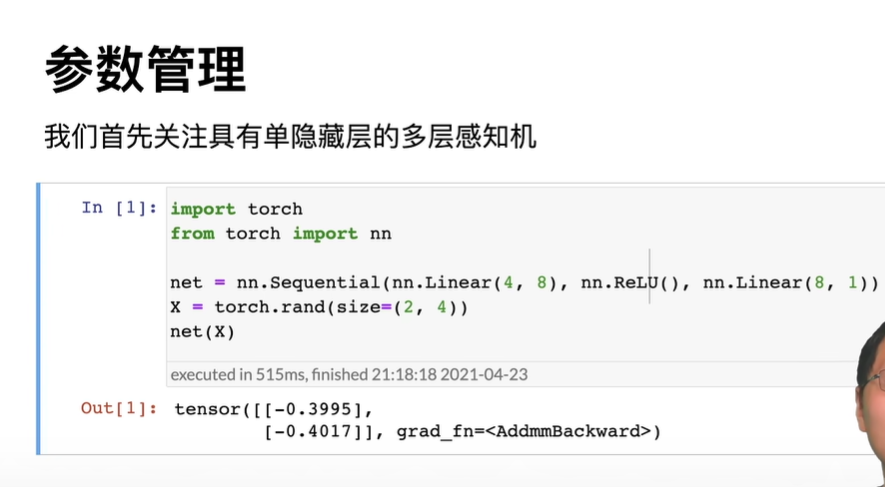

In [16]:
import torch
from torch import nn

#定义一个有单隐藏层的mlp （多层感知机）

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[0.2796],
        [0.2112]], grad_fn=<AddmmBackward0>)

In [19]:
# 我们可以通过索引来访问模型的任意层。 这就像模型是一个列表一样，每层的参数都在其属性中。 
# 如下所示，我们可以检查第二个全连接层的参数。
# net【2】即访问的时最后一层
print(net[2].state_dict())

OrderedDict([('weight', tensor([[ 0.0251, -0.0721, -0.0937,  0.2448, -0.0195,  0.2677,  0.1513, -0.1797]])), ('bias', tensor([0.2242]))])


In [20]:
net[2]

Linear(in_features=8, out_features=1, bias=True)

In [21]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.2242], requires_grad=True)
tensor([0.2242])


In [22]:
#可以通过.grad来访问梯度
net[2].weight.grad == None

True

In [23]:
# 5.2.1.2. 一次性访问所有参数
# 当我们需要对所有参数执行操作时，逐个访问它们可能会很麻烦。 
# 当我们处理更复杂的块（例如，嵌套块）时，情况可能会变得特别复杂， 因为我们需要递归整个树来提取每个子块的参数。 
# 下面，我们将通过演示来比较访问第一个全连接层的参数和访问所有层。

In [24]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [25]:
net.state_dict()['2.bias'].data

tensor([0.2242])

In [26]:
# 从嵌套块收集参数
# 让我们看看，如果我们将多个块相互嵌套，参数命名约定是如何工作的。 
# 我们首先定义一个生成块的函数（可以说是“块工厂”），然后将这些块组合到更大的块中。
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)


tensor([[0.4756],
        [0.4755]], grad_fn=<AddmmBackward0>)

In [28]:
print(rgnet) #可以看到神经网络的结构

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


In [29]:
rgnet[0][1][0].bias.data

tensor([-0.0808, -0.3323,  0.1229, -0.3896,  0.0214,  0.3958,  0.3078, -0.1379])

In [31]:
# 内置初始化深度学习框架提供默认随机初始化，
# 也允许我们创建自定义初始化方法，满足我们通过其他规则实现初始化权重。
def init_normal(m):
    if type(m) == nn.Linear:  # 如果这个m是一个线性层
        nn.init.normal_(m.weight, mean=0, std=0.01)  
        # 将其权重初始化为均值为0，标准差为0.01的正态分布
        nn.init.zeros_(m.bias)  # 将其偏置初始化为0

# 将自定义的初始化方法应用于网络
net.apply(init_normal)

# 打印第一个线性层的第一个权重和偏置
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0116,  0.0100, -0.0169,  0.0089]), tensor(0.))

In [33]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [34]:
#对某些块应用不同的初始化方法
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.6206, -0.4770, -0.2893, -0.6050])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


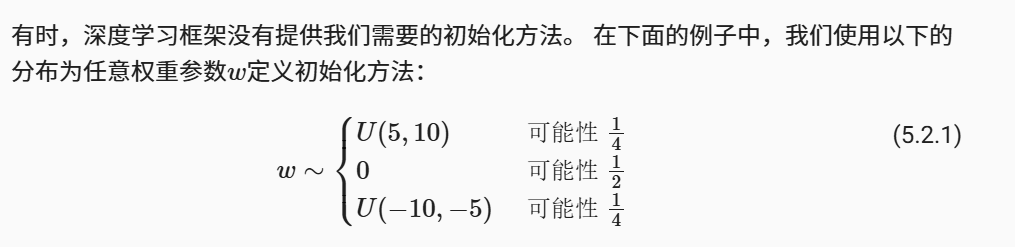

In [35]:
def my_init(m):
    if type(m) == nn.Linear:
        # 打印初始化信息，显示参数名称和形状
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        # 将权重初始化为均匀分布的随机数，范围在 -10 到 10 之间
        nn.init.uniform_(m.weight, -10, 10)
        # 通过将权重的绝对值小于5的元素置零来修改权重
        m.weight.data *= m.weight.data.abs() >= 5

In [36]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  0.5230,  0.7107,  0.3950])

In [37]:
#参数绑定 不同层的权重进行共享
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8, 8)

# 定义一个包含共享层的神经网络
net = nn.Sequential(
    nn.Linear(4, 8),   # 第一个线性层，将输入从4维变为8维
    nn.ReLU(),        # ReLU激活函数
    shared,           # 共享的线性层
    nn.ReLU(),        # ReLU激活函数
    shared,           # 再次使用共享的线性层
    nn.ReLU(),        # ReLU激活函数
    nn.Linear(8, 1)   # 最后一个线性层，将输入从8维变为1维
)

# 假设X是网络的输入，执行一次前向传播
net(X)

# 检查共享层的参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])

# 修改共享层的一个参数，确保两个层的参数是同一个对象
net[2].weight.data[0, 0] = 100

# 再次检查共享层的参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])


tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


In [39]:
import torch
import torch.nn.functional as F
from torch import nn

# 定义一个自定义层，继承自 nn.Module
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()  # 调用父类 nn.Module 的构造函数

    def forward(self, X):
        # 前向传播函数，接收输入 X 并返回中心化后的输出
        return X - X.mean()

In [40]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [41]:
# 我们可以将层作为组件合并到更复杂的模型中。
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

In [42]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(6.5193e-09, grad_fn=<MeanBackward0>)

In [43]:
import torch
import torch.nn.functional as F
from torch import nn

# 定义一个自定义线性层，继承自 nn.Module
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()  # 调用父类 nn.Module 的构造函数
        # 初始化权重参数，形状为 (in_units, units)，使用标准正态分布进行初始化
        self.weight = nn.Parameter(torch.randn(in_units, units))
        # 初始化偏置参数，形状为 (units,)，使用标准正态分布进行初始化
        self.bias = nn.Parameter(torch.randn(units,))
    
    def forward(self, X):
        # 计算线性变换：X * weight + bias
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        # 应用 ReLU 激活函数
        return F.relu(linear)

In [44]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[-2.1659,  1.1186,  0.3836],
        [ 0.5676,  1.2859, -0.5868],
        [ 0.2805,  1.2573, -1.9840],
        [ 1.4951,  0.0511,  1.3448],
        [-2.9560,  1.1972, -1.2148]], requires_grad=True)

In [45]:
linear(torch.rand(2, 5))

tensor([[0.0000, 1.9889, 0.0000],
        [1.5554, 1.2227, 1.4925]])

In [46]:
#自定义层构建模型，就像使用内置的全连接层一样使用自定义层。
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[3.2340],
        [0.0219]])

# 读写文件 加载和保存张量

In [47]:
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
#将这个向量存在目前目录的文件中
torch.save(x, 'x-file')

In [48]:
# 我们现在可以将存储在文件中的数据读回内存。
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

In [49]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [50]:
# 写入或读取从字符串映射到张量的字典。 
# 当我们要读取或写入模型中的所有权重时，这很方便。
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

保存单个权重向量（或其他张量）确实有用， 但是如果我们想保存整个模型，并在以后加载它们， 单独保存每个向量则会变得很麻烦。 毕竟，我们可能有数百个参数散布在各处。 因此，深度学习框架提供了内置函数来保存和加载整个网络。 需要注意的一个重要细节是，这将保存模型的参数而不是保存整个模型。 例如，如果我们有一个3层多层感知机，我们需要单独指定架构。 因为模型本身可以包含任意代码，所以模型本身难以序列化。 因此，为了恢复模型，我们需要用代码生成架构， 然后从磁盘加载参数。 让我们从熟悉的多层感知机开始尝试一下。

In [51]:
# 加载和保存模型的权重
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

In [52]:
# 我们将模型的参数存储在一个叫做“mlp.params”的文件中。
#将模型全部参数存成一个字典
torch.save(net.state_dict(), 'mlp.params')

In [53]:
# 多层感知机模型的一个备份。 这里我们不需要随机初始化模型参数，
# 而是直接读取文件中存储的参数。
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [54]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])